# Classification of Saint-Petersburg Metro Stations
## Introduction
Saint-Petersburg Metro has 72 stations and is the 26th busiest metro system in the world. It is used by more than 2 million people daily. 

For this project, we want to look at the neighborhoods surrounding metro stations and classify them by primary usage. E.g. if there are no professional places in a neighborhood its residents are likely to travel to other areas for work. 

This data is useful for city planners to learn where from and where to people are most likely to travel for work and leisure. This can help either businessmen to pick neighborhood to build and develop a new venue.


In [11]:
import pandas as pd
import numpy as np
import json
import requests
import folium
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
# import re

# pd.set_option('max_rows', 20)

### Ссылки УДАЛИТЬ

https://towardsdatascience.com/classification-of-moscow-metro-stations-using-foursquare-data-fb8aad3e0e4

https://github.com/theptyza/map_moscow_metro_foursquare/blob/master/Moscow.ipynb

https://github.com/theptyza/map_moscow_metro_foursquare/tree/master/map

https://github.com/theptyza/map_moscow_metro_foursquare
Ссылка справка по координатам

https://www.ibm.com/developerworks/ru/library/j-coordconvert/index.html


Работа со строками

https://www.cyberforum.ru/python-beginners/thread2244892.html

Предыдущий ноутбук по обработке данных

https://colab.research.google.com/drive/1-_WaMNaxwilwQlirho1HWpnIvTlNf1mi?usp=sharing

Образец доклада

https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DP0701EN/sample_submission/Predicting_the_Improvement_of_NBA_players_Report.pdf

Фолиум

https://python-visualization.github.io/folium/quickstart.html




## Data
We'll need data on the location of stations and on the venues closest to them.

1. List of stations and their geographical coordinates — scraped from [this Wikipedia page](https://en.wikipedia.org/wiki/List_of_Saint_Petersburg_Metro_stations) and [its Russian version](https://ru.wikipedia.org/wiki/Список_станций_Петербургского_метрополитена). 

2. Foursquare API to explore venue types surrounding each station. Foursquare outlines these high-level venue categories with more sub-categories:
*   Arts & Entertainment 
*   College & University 
*   Event 
*   Food 
*   Nightlife Spot 
*   Outdoors & Recreation 
*   Professional & Other Places 
*   Residence 
*   Shop & Service 
*   Travel & Transport

We’ll be querying the number of venues in each category in a 1500m radius around each station. This radius was chosen because 1500m is a quite reasonable walking distance (~15 min). 

### List of stations and their geographical coordinates

- Get the list of stations from English Wikipedia page
- Get stations coordinates from Russian Wiki page
- Clean up the second df and convert DMS coordinates into DD format
- Merge two dataframes (names and coors) into final one and save it in `.csv` table 
- PROFIT!

In [ ]:
# read station names and respective lines from URL 
wiki_url_stations = 'https://en.wikipedia.org/wiki/List_of_Saint_Petersburg_Metro_stations'
wiki_page = requests.get(wiki_url_stations)

# convert html into first pandas dataframe
wiki_raw = pd.read_html(wiki_page.content, header = 0)[0]
df_stations_only = wiki_raw[['English', 'Russian', 'Line']]
# df_stations_only.sort_values(by=['Russian'])

# manually set some values since the table is not good
df_stations_only.at[12, 'English'] = 'Tekhnologichesky Institut I'
df_stations_only.at[12, 'Russian'] = 'Технологический институт-1'
df_stations_only.at[29, 'English'] = 'Tekhnologichesky Institut II'
df_stations_only.at[29, 'Russian'] = 'Технологический институт-2'
df_stations_only.at[38, 'English'] = 'Zenit'
df_stations_only.at[38, 'Russian'] = 'Зенит'
df_stations_only.at[43, 'Russian'] = 'Площадь Александра Невского-1'
df_stations_only.at[52, 'Russian'] = 'Площадь Александра Невского-2'

df_stations_only.sort_values(by=['Russian'])

,English,Russian,Line
16,Avtovo,Автово,M1
62,Admiralteyskaya,Адмиралтейская,M5
2,Akademicheskaya,Академическая,M1
13,Baltiyskaya,Балтийская,M1
37,Begovaya,Беговая,M3
67,Bukharestskaya,Бухарестская,M5
40,Vasileostrovskaya,Василеостровская,M3
10,Vladimirskaya,Владимирская,M1
66,Volkovskaya,Волковская,M5
6,Vyborgskaya,Выборгская,M1


In [ ]:
# read station coordinates from another URL 
wiki_url_coor = 'https://ru.wikipedia.org/wiki/Список_станций_Петербургского_метрополитена'
wiki_page_2 = requests.get(wiki_url_coor)


# convert html into second pandas dataframe
wiki_raw_2 = pd.read_html(wiki_page_2.content, header = 0)[1]
df_coor = wiki_raw_2[['Название станции', 'Координаты']]

# rename column names 
df_coor = df_coor.rename(columns={'Название станции': 'Russian', 'Координаты': 'Coordinates'})


for i in range(len(df_coor)):
    # clean 'Russian' column values from old names
    s = df_coor.at[i, 'Russian']
    s = s if s.find(' до ') == -1 else s[:s.find(' до ')]
    df_coor.at[i, 'Russian'] = s

    # convert coordinates from DMS to DD
    ss = df_coor.at[i, 'Coordinates']
    first_coor = int(ss[:2]) + int(ss[3:5])/60 + int(ss[6:8])/3600
    second_coor = int(ss[16:18]) + int(ss[19:21])/60 + int(ss[22:24])/3600
    df_coor.at[i, 'Coordinates'] = str(first_coor) + ',' + str(second_coor)

# manually set some values since the table is not good either
df_coor.at[38, 'Russian'] = 'Зенит'
df_coor.at[43, 'Russian'] = 'Площадь Александра Невского-1'
df_coor.at[52, 'Russian'] = 'Площадь Александра Невского-2'
df_coor.at[12, 'Russian'] = 'Технологический институт-1'
df_coor.at[29, 'Russian'] = 'Технологический институт-2'

df_coor.sort_values(by=['Russian'])

,Russian,Coordinates
16,Автово,"59.867222222222225,30.261388888888888"
62,Адмиралтейская,"59.93583333333333,30.315"
2,Академическая,"60.0125,30.395833333333332"
13,Балтийская,"59.907222222222224,30.299444444444447"
37,Беговая,"59.98722222222222,30.202222222222222"
67,Бухарестская,"59.88388888888889,30.36861111111111"
40,Василеостровская,"59.942499999999995,30.278055555555554"
10,Владимирская,"59.927499999999995,30.347777777777775"
66,Волковская,"59.895833333333336,30.35777777777778"
6,Выборгская,"59.971111111111114,30.3475"


In [ ]:
# merge two dataframes by  'Russian' column
df_stations_full = pd.merge(df_stations_only, df_coor, on=['Russian'])

# move 'Line' column forward
col_name = 'Line'
first_col = df_stations_full.pop(col_name)
df_stations_full.insert(0, col_name, first_col)

# save dataframe into .csv file
df_stations_full.to_csv('SPb_Metro_stations.csv', index=False)

print(len(df_stations_full))
df_stations_full.sort_values(by=['Russian'])

72


,Line,English,Russian,Coordinates
16,M1,Avtovo,Автово,"59.867222222222225,30.261388888888888"
62,M5,Admiralteyskaya,Адмиралтейская,"59.93583333333333,30.315"
2,M1,Akademicheskaya,Академическая,"60.0125,30.395833333333332"
13,M1,Baltiyskaya,Балтийская,"59.907222222222224,30.299444444444447"
37,M3,Begovaya,Беговая,"59.98722222222222,30.202222222222222"
67,M5,Bukharestskaya,Бухарестская,"59.88388888888889,30.36861111111111"
40,M3,Vasileostrovskaya,Василеостровская,"59.942499999999995,30.278055555555554"
10,M1,Vladimirskaya,Владимирская,"59.927499999999995,30.347777777777775"
66,M5,Volkovskaya,Волковская,"59.895833333333336,30.35777777777778"
6,M1,Vyborgskaya,Выборгская,"59.971111111111114,30.3475"


### Visualisation of stations and lines

In [12]:
# a new dataframe from .csv file

stations_df = pd.read_csv('/content/SPb_Metro_stations.csv')
stations_df['Coordinates'].head()

0     60.05027777777777,30.442222222222224
1                60.035,30.418055555555558
2               60.0125,30.395833333333332
3     60.00861111111111,30.370833333333334
4    59.999722222222225,30.366666666666667
Name: Coordinates, dtype: object

In [13]:
# Color codes for lines
line_colors = {
    'M1':'#EF161E',
    'M2':'#2DBE2C',
    'M3':'#0078BE',
    'M4':'#00BFFF',
    'M5':'#8D5B2D',
    }

# create map of Saint-Petersburg with all stations
map_spb_metro = folium.Map(location=[59.9339, 30.3061], zoom_start=10)
prev_coordinates = None
prev_line = 'M1'

# create colored circles on stations
for line, station, coordinates in zip(stations_df['Line'], stations_df['English'], stations_df['Coordinates']):
    latlong = [float(x) for x in coordinates.split(',')] 
    folium.Circle(
        latlong,
        popup=station,
        radius=20,
        color=line_colors[line],
        fill=True,
        ).add_to(map_spb_metro)
    if line != prev_line:
        prev_coordinates = None    
    if prev_coordinates != None:
        folium.PolyLine([prev_coordinates, latlong], color=line_colors[line]).add_to(map_spb_metro)    
    prev_line = line
    prev_coordinates = latlong    

# draw lines
def draw_lines(dataframe, map_object, opacity=1):
    prev_coordinates = None
    prev_line = '1'
    for line, coordinates in zip(dataframe['Line'], dataframe['Coordinates']):
        latlong = [float(x) for x in coordinates.split(',')]
        #don't draw line if line number changed
        if line != prev_line:
            prev_coordinates = None
        if prev_coordinates != None:
            folium.PolyLine([prev_coordinates, latlong], color=line_colors[line], opacity=opacity).add_to(map_object)
        prev_line = line
        prev_coordinates = latlong    
   
draw_lines(stations_df, map_spb_metro)
map_spb_metro

### Data from Foursquare

In [15]:
secrets = json.load(open('secrets.json'))
CLIENT_ID = secrets['CLIENT_ID']
CLIENT_SECRET = secrets['CLIENT_SECRET']
VERSION = secrets['VERSION']

In [16]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION)
            
# make the GET request
results = requests.get(categories_url).json()

In [17]:
len(results['response']['categories'])

10

In [18]:
categories_list = []
# Let's print only the top-level categories and their IDs and also add them to categories_list

def print_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        print(out + category['name'] + ' (' + category['id'] + ')')
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))
        
print_categories(results['response']['categories'], 0, 0)

Arts & Entertainment (4d4b7104d754a06370d81259)
College & University (4d4b7105d754a06372d81259)
Event (4d4b7105d754a06373d81259)
Food (4d4b7105d754a06374d81259)
Nightlife Spot (4d4b7105d754a06376d81259)
Outdoors & Recreation (4d4b7105d754a06377d81259)
Professional & Other Places (4d4b7105d754a06375d81259)
Residence (4e67e38e036454776db1fb3a)
Shop & Service (4d4b7105d754a06378d81259)
Travel & Transport (4d4b7105d754a06379d81259)


## Methodology

We use the foursquare explore API with categoryId to query the number of venues of each category in a specific radius. The response contains a totalResults value for the specified coordinates, radius and category.

In [19]:
def get_venues_count(ll, radius, categoryId):
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                ll,
                radius,
                categoryId)

    # make the GET request
    return requests.get(explore_url).json()['response']['totalResults']

In [20]:
#create new dataframe to store venues data

stations_venues_df = stations_df.copy()
for c in categories_list:
    stations_venues_df[c[0]] = 0

In [21]:
# request number of venues, store result as CSV

for i, row in stations_venues_df.iterrows():
    print(i)
    for c in categories_list:        
        stations_venues_df.loc[i, c[0]] = get_venues_count(stations_venues_df.Coordinates.iloc[i], radius=1000, categoryId=c[1])
    stations_venues_df.to_csv('stations_venues.csv')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71


In [23]:
#Read already stored CSV
stations_venues_df = pd.read_csv('stations_venues.csv', index_col=0)
stations_venues_df.head()

,Line,English,Russian,Coordinates,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,M1,Devyatkino,Девяткино,"60.05027777777777,30.442222222222224",9,0,1,23,7,12,32,22,51,5
1,M1,Grazhdansky Prospekt,Гражданский проспект,"60.035,30.418055555555558",8,25,0,41,8,29,100,86,99,15
2,M1,Akademicheskaya,Академическая,"60.0125,30.395833333333332",8,43,0,51,11,35,85,78,110,13
3,M1,Politekhnicheskaya,Политехническая,"60.00861111111111,30.370833333333334",4,76,0,30,4,26,65,23,48,10
4,M1,Ploschad Muzhestva,Площадь Мужества,"59.999722222222225,30.366666666666667",4,58,0,28,4,32,66,32,77,15



### Exploratory analysis & basic cleanup
Plot the number of venues as boxplots


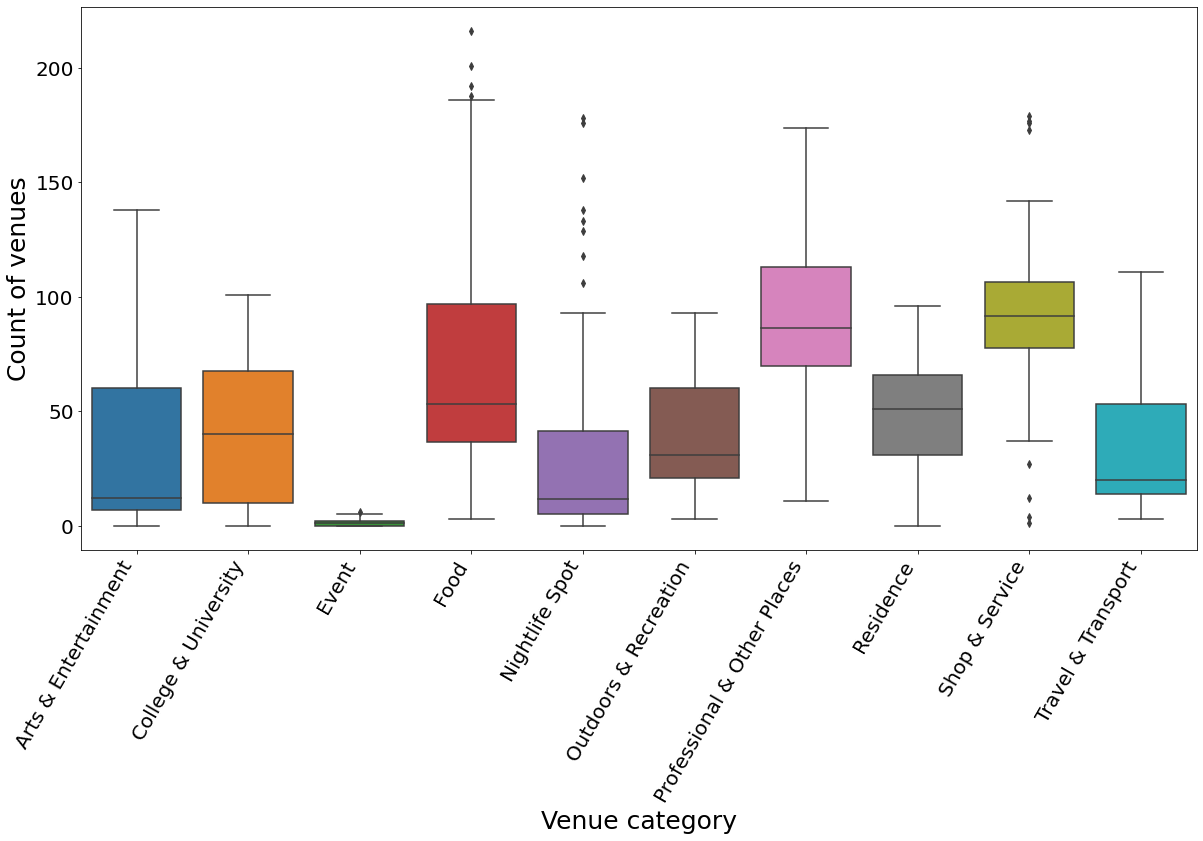

In [25]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = stations_venues_df)
ax.set_ylabel('Count of venues', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=60, ha='right')

plt.show()

The most frequent venue categories are professional, shop&service and food. Event has very little data, let's discard it from both the dataframe and the list of categories.

In [26]:
stations_venues_df.drop('Event', 1, inplace=True)
categories_list = list(filter(lambda x: x[0] != 'Event', categories_list))

In [27]:
stations_venues_df.head()

,Line,English,Russian,Coordinates,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,M1,Devyatkino,Девяткино,"60.05027777777777,30.442222222222224",9,0,23,7,12,32,22,51,5
1,M1,Grazhdansky Prospekt,Гражданский проспект,"60.035,30.418055555555558",8,25,41,8,29,100,86,99,15
2,M1,Akademicheskaya,Академическая,"60.0125,30.395833333333332",8,43,51,11,35,85,78,110,13
3,M1,Politekhnicheskaya,Политехническая,"60.00861111111111,30.370833333333334",4,76,30,4,26,65,23,48,10
4,M1,Ploschad Muzhestva,Площадь Мужества,"59.999722222222225,30.366666666666667",4,58,28,4,32,66,32,77,15


### Data preparation

Let's normalize the data using MinMaxScaler (scale from 0 to 1). This scales the data and provides an easy to interpret score at the same time.


In [28]:
from sklearn.preprocessing import MinMaxScaler

X = stations_venues_df.values[:,4:]
cluster_dataset = MinMaxScaler().fit_transform(X)

In [29]:
cluster_df = pd.DataFrame(cluster_dataset)
cluster_df.columns = [c[0] for c in categories_list]
cluster_df.head()

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0.065217,0.000000,0.093897,0.039326,0.100000,0.128834,0.229167,0.280899,0.018519
1,0.057971,0.247525,0.178404,0.044944,0.288889,0.546012,0.895833,0.550562,0.111111
2,0.057971,0.425743,0.225352,0.061798,0.355556,0.453988,0.812500,0.612360,0.092593
3,0.028986,0.752475,0.126761,0.022472,0.255556,0.331288,0.239583,0.264045,0.064815
4,0.028986,0.574257,0.117371,0.022472,0.322222,0.337423,0.333333,0.426966,0.111111


Visualize the scaled data.

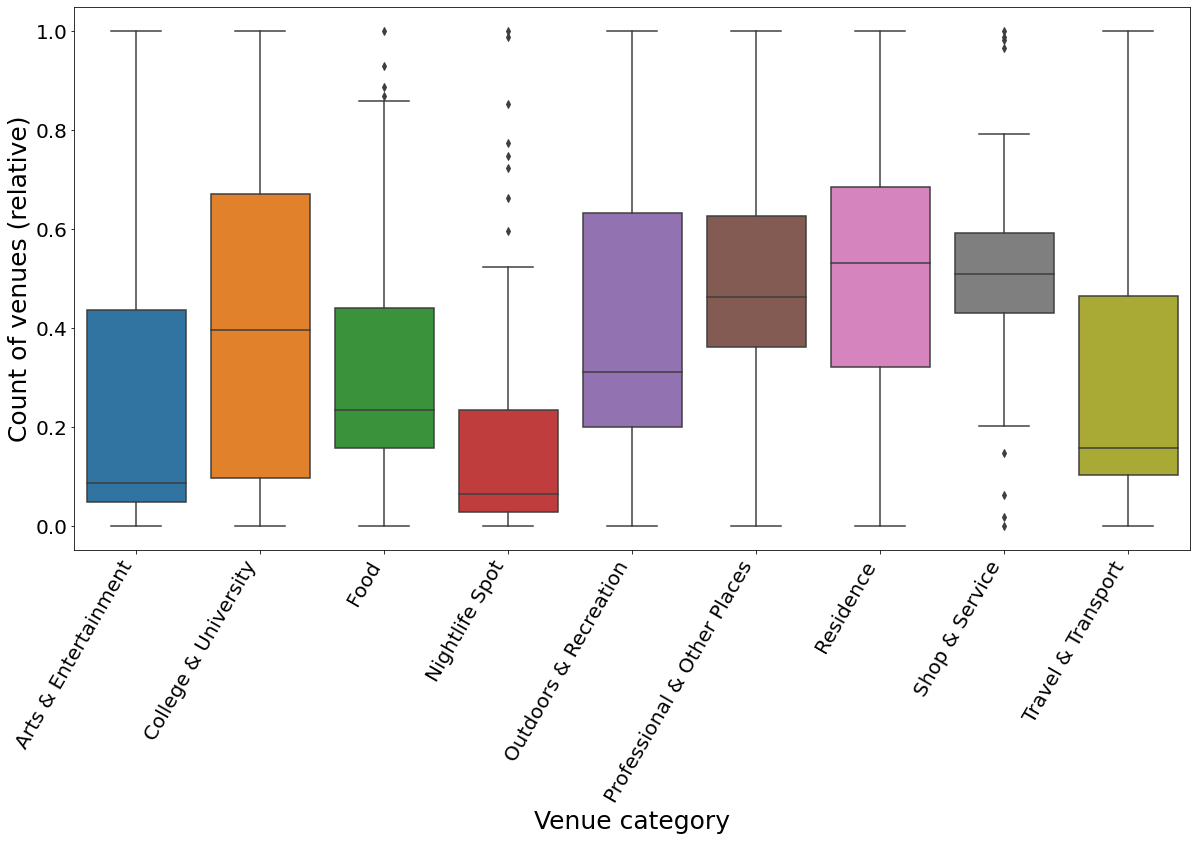

In [31]:
plt.figure(figsize=(20, 10))
# plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = cluster_df)
ax.set_ylabel('Count of venues (relative)', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=60, ha='right')

plt.show()

### Clustering

We'll be using k-means clustering. These were preliminary results with different number of clusters:

- 2 clusters only show the uptown/downtown divide
- 3 clusters add clustering within the downtown
- 4 clusters also identify neighborhoods with very low number of venues
- 5 and more clusters are difficult to interpret

For the final analysis let's settle on 4 clusters.


In [32]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_df)

kmeans_labels = kmeans.labels_
# Change label numbers so they go from highest scores to lowest
replace_labels = {0:2, 1:0, 2:3, 3:1}
for i in range(len(kmeans_labels)):
    kmeans_labels[i] = replace_labels[kmeans_labels[i]]

stations_clusters_df = stations_venues_df.copy()
stations_clusters_df['Cluster'] = kmeans_labels
stations_clusters_minmax_df = cluster_df.copy()
stations_clusters_minmax_df['Cluster'] = kmeans_labels
stations_clusters_minmax_df['English'] = stations_df['English']
stations_clusters_minmax_df['Coordinates'] = stations_df['Coordinates']

Visualize the clusters with boxplots

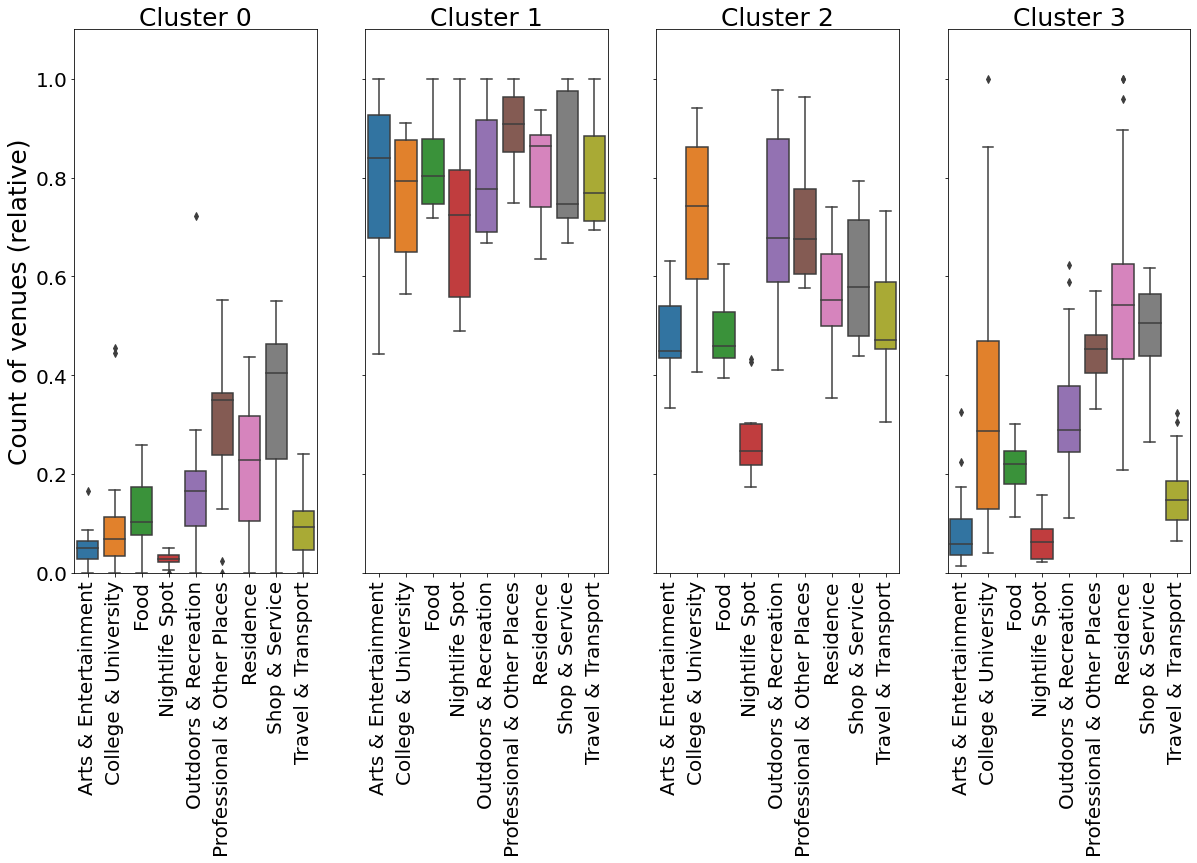

In [33]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1,kclusters, figsize=(20, 10), sharey=True)

axes[0].set_ylabel('Count of venues (relative)', fontsize=25)
#plt.set_xlabel('Venue category', fontsize='x-large')

for k in range(kclusters):
    #Set same y axis limits
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = stations_clusters_minmax_df[stations_clusters_minmax_df['Cluster'] == k].drop('Cluster',1), ax=axes[k])

plt.show()

Map the data. For each station we'll display top 3 venue categories.


In [34]:
#create map of Saint-Petersburg with all stations
map_spb_metro = folium.Map(location=[59.9339, 30.3061], zoom_start=10)

draw_lines(stations_df, map_spb_metro, 0.9)

#add markers
for i, station, coordinates, cluster in zip(stations_clusters_minmax_df.index,
                                         stations_clusters_minmax_df['English'],
                                         stations_clusters_minmax_df['Coordinates'],
                                         stations_clusters_minmax_df['Cluster']):
    latlong = [float(x) for x in coordinates.split(',')]    
    #colors = sns.color_palette(None, kclusters).as_hex()
    colors=['blue','green','orange','red']
    #Calculate top 3 categories for each station
    station_series = stations_clusters_minmax_df.iloc[i]
    top_categories_dict = {}
    for cat in categories_list:
        top_categories_dict[cat[0]] = station_series[cat[0]]
    top_categories = sorted(top_categories_dict.items(), key = lambda x: x[1], reverse=True)
    popup='<b>{}</b><br>Cluster {}<br>1. {} {}<br>2. {} {}<br>3. {} {}'.format(
        station,
        cluster,
        top_categories[0][0],
        "{0:.2f}".format(top_categories[0][1]),
        top_categories[1][0],
        "{0:.2f}".format(top_categories[1][1]),
        top_categories[2][0],
        "{0:.2f}".format(top_categories[2][1]))
    folium.CircleMarker(
        latlong,
        fill=True,
        fill_opacity=0.5,
        popup=folium.Popup(popup, max_width = 300),
        radius=5,
        color=colors[cluster]
    ).add_to(map_spb_metro)
    
map_spb_metro

In [37]:
# save the result map into .html file 

map_spb_metro.save('map_index.html')

## Results

Here is how we can characterize the clusters by looking at venue scores

- Cluster 0 (Blue) has low marks across the board. These appear to be underdeveloped areas. 
- Cluster 1 (Green) has consistently high scores for all venue categories. This is the most diversely developed part of the city.
- Cluster 2 (Orange) has highest marks for Professional&Other Places. This is the business part(s) of the city.
- Cluster 3 (Red) has lower marks with best scores in Residence and College&Universitues.

Plotting the clusters on a map shows us that

Cluster 1 is the oldest central part of the city.
Cluster 2 is also downtown and business area. Most of these stations have excellent transit accessibility.
Clusters 0 and 3 tend to be at the outskirts but some are more centrally located.

Some stations were classified as Cluster 4 despite being more centrally and accessibly located. This could be a legacy of the closed and abandoned factories. 

## Discussion

To be fair, Foursquare data isn’t all-encompassing. The highest number of venues are in the Food and Shop & Service categories. Data doesn’t take into account a venue’s size (e.g. a university building attracts a lot more people that a hot dog stand – each of them is still one Foursquare “venue”).




## Conclusion

Foursquare data is limited but can provide insights into a city’s development. This data could be combined with other sources (e.g. city data on number of residents) to provide more accurate results.